In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To show images
from PIL import Image

C:\Users\sudha\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def create_df(dataset):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for filename in filenames:
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')
                
    df = pd.DataFrame({'Image Path': image_paths, 
                       'Label': labels}) 
    
    return df

train_dir = r"C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data"
df = create_df(train_dir)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 7462
Number of test samples: 1600
Number of validation samples: 1599


In [3]:
def show_history_plot(history):
    training_accuracy = history.history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history.history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    
    plt.tight_layout()
    plt.show()

In [4]:

def show_conf_matrix(model, test_gen):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)  
    y_true = test_gen.classes  
    
    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)

    # Plot the confusion matrix 
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)  
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7)) 
    plt.show()

In [5]:
def evaluation_matrix(model, train_gen, valid_gen, test_gen):
    train_steps = len(train_df) // batch_size
    valid_steps = len(valid_df) // batch_size
    test_steps = len(test_df) // batch_size
    
    train_score = model.evaluate(train_gen, steps=train_steps, verbose=0)
    valid_score = model.evaluate(valid_gen, steps=valid_steps, verbose=0)
    test_score = model.evaluate(test_gen, steps=test_steps, verbose=0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

In [6]:
batch_size = 40
train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe(train_df, 
                                                     x_col='Image Path', 
                                                     y_col='Label', 
                                                     target_size=(224, 224), 
                                                     class_mode='categorical',
                                                     color_mode='rgb', 
                                                     shuffle=True, 
                                                     batch_size=batch_size)

valid_gen = valid_data_generator.flow_from_dataframe(valid_df, 
                                                     x_col='Image Path', 
                                                     y_col='Label', 
                                                     target_size=(224, 224), 
                                                     class_mode='categorical',
                                                     color_mode='rgb', 
                                                     shuffle=False, 
                                                     batch_size=batch_size)

test_gen = valid_data_generator.flow_from_dataframe(test_df, 
                                                    x_col='Image Path', 
                                                    y_col='Label', 
                                                    target_size=(224, 224), 
                                                    class_mode='categorical',
                                                    color_mode='rgb', 
                                                    shuffle=False, 
                                                    batch_size=batch_size)



Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


In [7]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(2, activation='softmax')  
    ])
    return model


cnn_model = create_cnn_model((224, 224, 3))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [8]:
history = cnn_model.fit(train_gen,
                        steps_per_epoch=len(train_df) // batch_size,
                        validation_data=valid_gen,
                        validation_steps=len(valid_df) // batch_size,
                        epochs=10,  
                        verbose=1)

Epoch 1/10
186/186 [==============================] - 334s 2s/step - loss: 3.6505 - accuracy: 0.7897 - val_loss: 0.4682 - val_accuracy: 0.7968
Epoch 2/10
186/186 [==============================] - 320s 2s/step - loss: 0.4384 - accuracy: 0.8118 - val_loss: 0.4530 - val_accuracy: 0.8128
Epoch 3/10
186/186 [==============================] - 330s 2s/step - loss: 0.4056 - accuracy: 0.8298 - val_loss: 0.4422 - val_accuracy: 0.8154
Epoch 4/10
186/186 [==============================] - 267s 1s/step - loss: 0.3828 - accuracy: 0.8426 - val_loss: 0.4271 - val_accuracy: 0.8237
Epoch 5/10
186/186 [==============================] - 266s 1s/step - loss: 0.3597 - accuracy: 0.8488 - val_loss: 0.4866 - val_accuracy: 0.7814
Epoch 6/10
186/186 [==============================] - 261s 1s/step - loss: 0.3312 - accuracy: 0.8601 - val_loss: 0.4611 - val_accuracy: 0.8231
Epoch 7/10
186/186 [==============================] - 268s 1s/step - loss: 0.3104 - accuracy: 0.8720 - val_loss: 0.4639 - val_accuracy: 0.8359

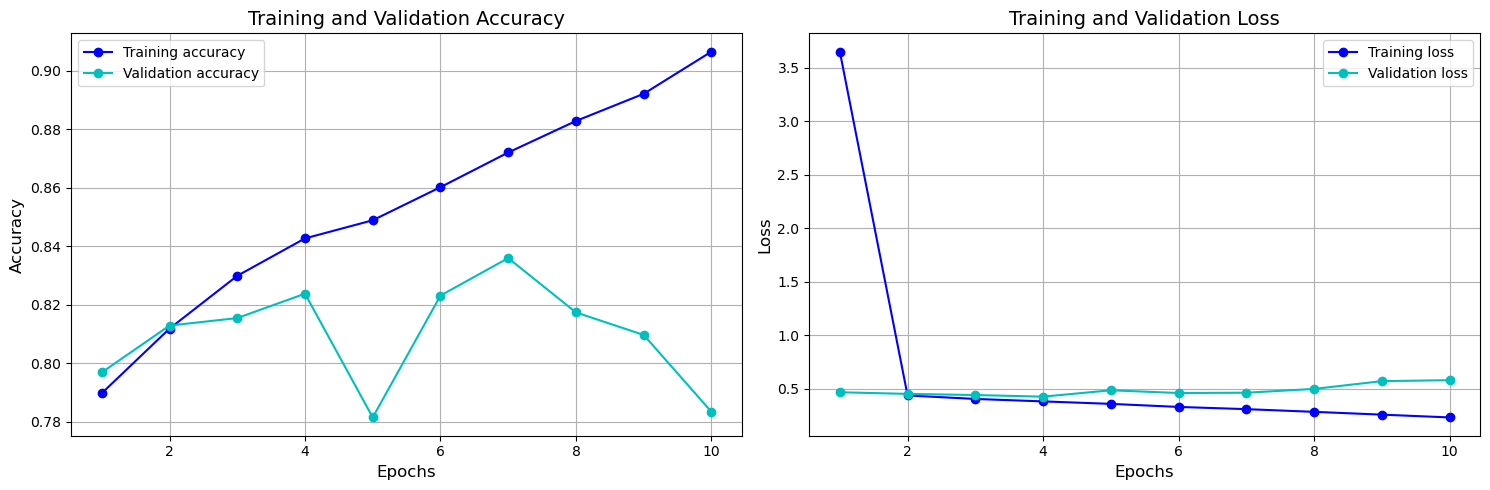

             Loss       Accuracy  
----------------------------------
Train        0.23514    0.90538   
Validation   0.58110    0.78333   
Test         0.53162    0.78312   


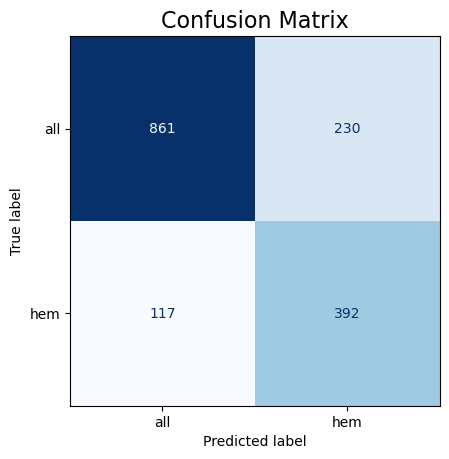

<Figure size 700x700 with 0 Axes>

In [9]:
show_history_plot(history)

# Evaluate the model
evaluation_matrix(cnn_model, train_gen, valid_gen, test_gen)

# Show confusion matrix
show_conf_matrix(cnn_model, test_gen)

Image path: C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data\fold_0\all\UID_11_7_3_all.bmp
Heatmap before normalization: [[3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]
 [3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]
 [3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]
 ...
 [3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]
 [3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]
 [3.798553e-09 3.798553e-09 3.798553e-09 ... 3.798553e-09 3.798553e-09
  3.798553e-09]]
Heatmap after normalization: [[0.09990292 0.09990292 0.09990292 ... 0.09990292 0.09990292 0.09990292]
 [0.09990292 0.09990292 0.09990292 ... 0.09990292 0.09990292 0.09990292]
 [0.09990292 0.09990292 0.09990292 ... 0.09990292 0.09990292 0.09990292]
 ...
 [0.09990292 0.09990292 0.09990292 ... 0.09990292 0.099

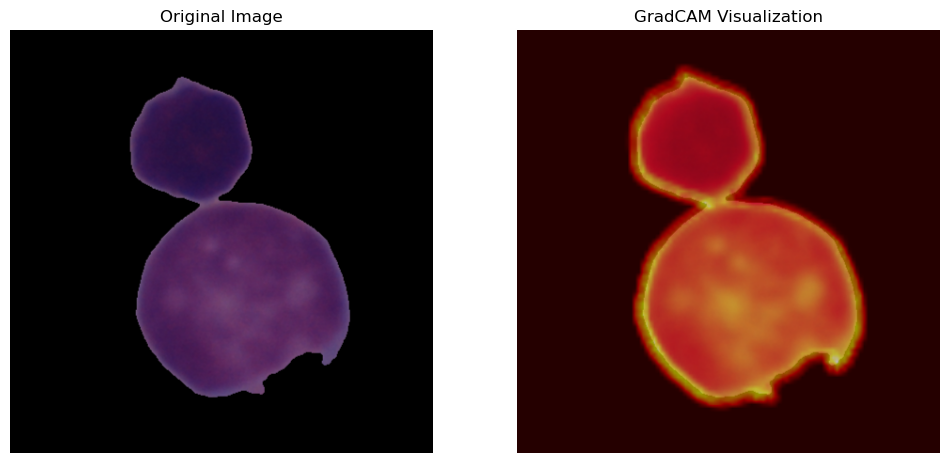

Image path: C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data\fold_2\hem\UID_H13_17_2_hem.bmp
Heatmap before normalization: [[1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]
 [1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]
 [1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]
 ...
 [1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]
 [1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]
 [1.1788442e-10 1.1788442e-10 1.1788442e-10 ... 1.1788442e-10
  1.1788442e-10 1.1788442e-10]]
Heatmap after normalization: [[0.12609477 0.12609477 0.12609477 ... 0.12609477 0.12609477 0.12609477]
 [0.12609477 0.12609477 0.12609477 ... 0.12609477 0.12609477 0.12609477]
 [0.12609477 0.12609477 0.12609477 ... 0.12609477 0.12609477 0.12609477]
 ...
 [0.12609477 0.12

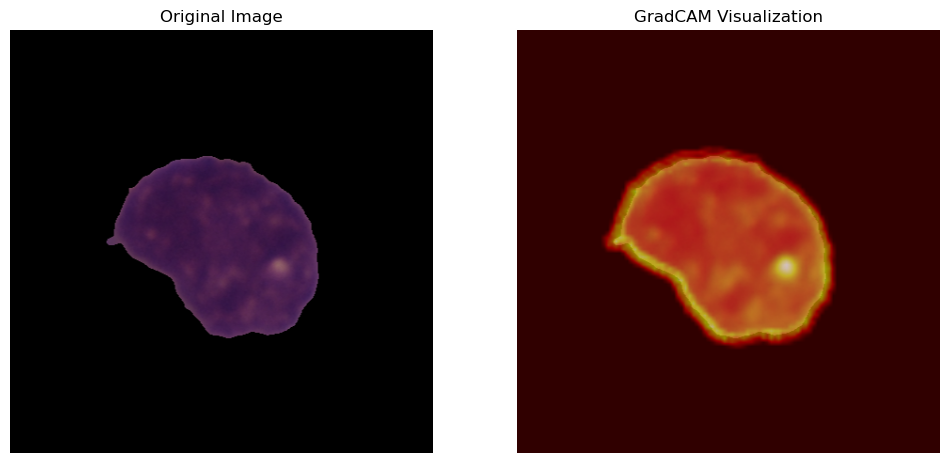

Image path: C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data\fold_0\hem\UID_H11_6_2_hem.bmp
Heatmap before normalization: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Heatmap after normalization: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


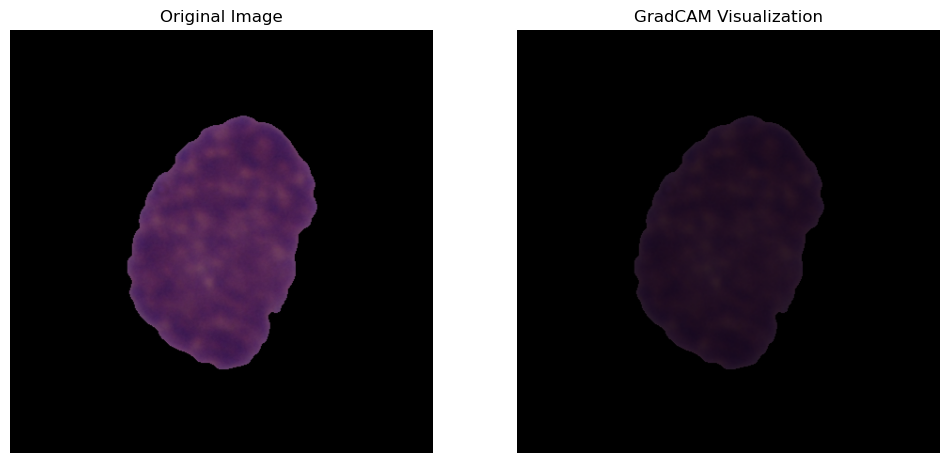

Image path: C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data\fold_0\all\UID_45_28_2_all.bmp
Heatmap before normalization: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Heatmap after normalization: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


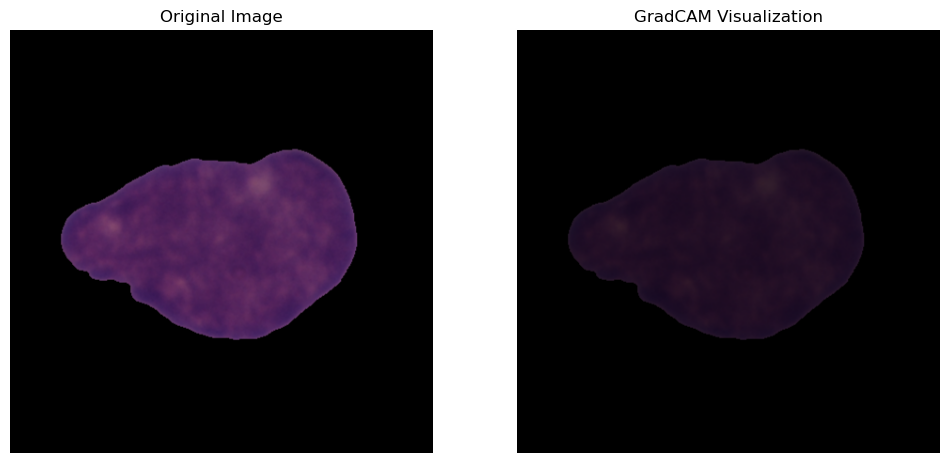

Image path: C:\Users\sudha\OneDrive\Desktop\Journal (Elsevier)\archive (3)\C-NMC_Leukemia\training_data\fold_0\all\UID_45_29_7_all.bmp
Heatmap before normalization: [[6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]
 [6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]
 [6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]
 ...
 [6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]
 [6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]
 [6.1745725e-10 6.1745725e-10 6.1745725e-10 ... 6.1745725e-10
  6.1745725e-10 6.1745725e-10]]
Heatmap after normalization: [[0.12463733 0.12463733 0.12463733 ... 0.12463733 0.12463733 0.12463733]
 [0.12463733 0.12463733 0.12463733 ... 0.12463733 0.12463733 0.12463733]
 [0.12463733 0.12463733 0.12463733 ... 0.12463733 0.12463733 0.12463733]
 ...
 [0.12463733 0.124

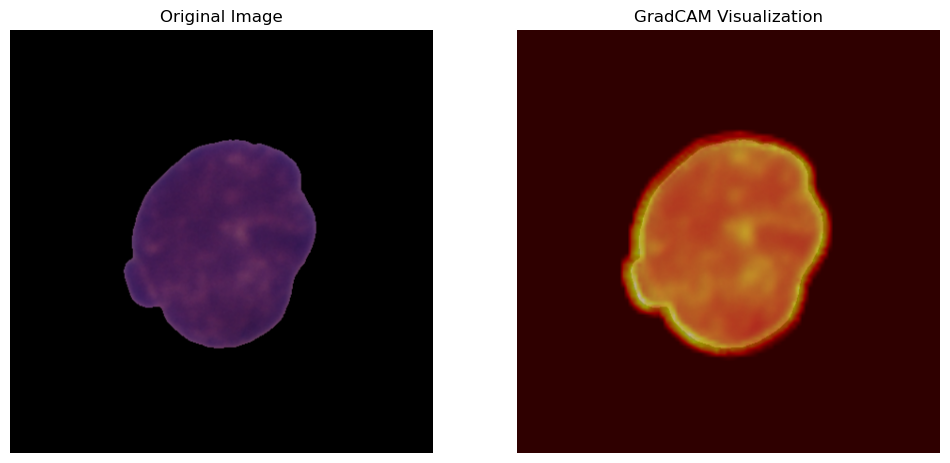

In [23]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    print("Heatmap before normalization:", heatmap)  # Print heatmap before normalization
    heatmap_max = np.max(heatmap)
    if heatmap_max > 0:
        heatmap /= heatmap_max
    print("Heatmap after normalization:", heatmap)  # Print heatmap after normalization

    heatmap_normalized = np.clip(heatmap, 0, 1)  # Clip values to [0, 1] range
    heatmap = np.uint8(255 * heatmap_normalized)

    return heatmap

def gradcam_visualize(model, img_path, layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    heatmap = compute_gradcam(model, img_array, layer_name)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)  # Use a different colormap
    superimposed_img = cv2.addWeighted(img, 0.4, heatmap, 0.6, 0)  # Adjust the blending factor

    # Display the original image and GradCAM visualization side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display GradCAM visualization
    axes[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('GradCAM Visualization')
    axes[1].axis('off')

    plt.show()

# Choose the layer for visualization
layer_name = 'conv2d_1'  # Choose the appropriate layer

# Visualize GradCAM for some test images
for i in range(5):  # Visualize 5 images
    img_path = test_df.iloc[i]['Image Path']
    print(f"Image path: {img_path}")  # Print the image path
    gradcam_visualize(cnn_model, img_path, layer_name)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the true labels in y_true and predicted labels in y_pred_classes
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Compute precision
precision = precision_score(y_true, y_pred_classes)

# Compute recall
recall = recall_score(y_true, y_pred_classes)

# Compute F1-score
f1 = f1_score(y_true, y_pred_classes)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.783125
Precision: 0.6302250803858521
Recall: 0.7701375245579568
F1-score: 0.6931918656056587
